In [1]:
import random
import nltk
from nltk.corpus import words, brown, wordnet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import textstat
import matplotlib.pyplot as plt


In [2]:

# Desired outputs for the fitness function
DESIRED_OUTPUTS = {
    "rouge_l": 0.7,
    "readability": 8,
    "human_score": 4,
}



In [3]:
# Chromosome class represents an individual in the population
class Chromosome:
    def __init__(self, genes):
        self.genes = genes

    def to_prompt(self):
        prompt = " ".join(map(str, self.genes))
        # Ensure the prompt ends with a period
        return prompt.capitalize() + '.' if not prompt.endswith('.') else prompt


In [4]:

# Initialize the population with user input as a starting point
def initialize_population_with_user_input(user_prompt, population_size, prompt_length):
    population = []
    user_words = nltk.word_tokenize(user_prompt.lower())

    for _ in range(population_size):
        # Create initial genes with user words and their synonyms
        initial_genes = user_words + [get_synonym(word) for word in user_words for _ in range(prompt_length - len(user_words))]
        population.append(Chromosome(initial_genes))
    return population


In [5]:

# Perform crossover between two parents to create two children
def crossover(parent1, parent2):
    crossover_point1 = random.randint(0, len(parent1.genes) // 3)
    crossover_point2 = random.randint(len(parent1.genes) // 3, 2 * len(parent1.genes) // 3)

    child_genes1 = (
        parent1.genes[:crossover_point1] +
        parent2.genes[crossover_point1:crossover_point2] +
        parent1.genes[crossover_point2:]
    )

    child_genes2 = (
        parent2.genes[:crossover_point1] +
        parent1.genes[crossover_point1:crossover_point2] +
        parent2.genes[crossover_point2:]
    )

    child1 = Chromosome(child_genes1)
    child2 = Chromosome(child_genes2)
    return child1, child2

In [6]:
# Mutate a chromosome by changing a random word in the genes
def mutate_word(word, user_words):
    # Replace the word with a synonym if available, otherwise keep the original word
    return get_synonym(word) if word in user_words else word

# Mutate a chromosome by changing a random word in the genes
def mutate(chromosome, user_words, mutation_probability=0.2):
    mutated_genes = chromosome.genes.copy()

    index_to_mutate = random.randint(0, len(mutated_genes) - 1)
    mutated_genes[index_to_mutate] = mutate_word(mutated_genes[index_to_mutate], user_words)

    mutated_chromosome = Chromosome(mutated_genes)
    return mutated_chromosome



In [7]:

# Calculate readability using textstat library
def calculate_readability(text):
    return textstat.flesch_reading_ease(text)



In [8]:
# Fitness function evaluates the quality of a prompt
def fitness_function(chromosome, tokenizer, model):
    prompt = chromosome.to_prompt()
    encoded_prompt = tokenizer(prompt, return_tensors="pt")
    output = model(**encoded_prompt)

    # Extract ROUGE-L score and calculate readability
    rouge_l = output.get('rouge', {}).get('rouge-l', {}).get('f', 0.0)
    readability = calculate_readability(prompt)

    # Combine scores based on weights
    fitness = rouge_l * 0.6 + readability * 0.3 + DESIRED_OUTPUTS["human_score"] * 0.1
    return fitness


In [9]:

# Get a synonym for a word using NLTK WordNet
def get_synonym(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name()
            if synonym != word:
                synonyms.add(synonym)

    return random.choice(list(synonyms)) if synonyms else word


In [10]:

# Roulette wheel selection for choosing parents based on fitness
def roulette_wheel_selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    selection_probabilities = [score / total_fitness for score in fitness_scores]

    selected_index = random.choices(range(len(population)), weights=selection_probabilities)[0]
    return population[selected_index]


In [11]:
# Plot the performance of the genetic algorithm over iterations
def plot_performance(iterations, best_fitness_values):
    plt.plot(iterations, best_fitness_values, marker='o')
    plt.title('Genetic Algorithm Performance')
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.grid(True)
    plt.show()

In [37]:



# Get user input for the initial prompt
initial_prompt = input("Enter an initial prompt: ")

# Initialize the population with words from the user's prompt
population_size = 30
prompt_length = 15
population = initialize_population_with_user_input(initial_prompt, population_size, prompt_length)

# Load the pre-trained transformer model and tokenizer
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Run the genetic algorithm for a specified number of generations
num_generations = 100
mutation_probability = 0.5  # Define mutation probability here

best_fitness_values = []
average_fitness_values = []
iterations = []




for generation in range(num_generations):
    fitness_scores = [fitness_function(c, tokenizer, model) for c in population]

    new_population = []
    generation_fitness_values = []  # Store fitness scores for all individuals in the generation
    for _ in range(population_size):
        parent1 = roulette_wheel_selection(population, fitness_scores)
        parent2 = roulette_wheel_selection(population, fitness_scores)

        child1, child2 = crossover(parent1, parent2)

        # Mutate children with a certain probability
        if random.uniform(0, 1) < mutation_probability:
            child1 = mutate(child1, nltk.word_tokenize(initial_prompt.lower()))

        if random.uniform(0, 1) < mutation_probability:
            child2 = mutate(child2, nltk.word_tokenize(initial_prompt.lower()))

        new_population.append(child1)
        new_population.append(child2)

        # Calculate fitness for the current individual in the generation
        individual_fitness1 = fitness_function(child1, tokenizer, model)
        individual_fitness2 = fitness_function(child2, tokenizer, model)
        generation_fitness_values.extend([individual_fitness1, individual_fitness2])

    population = new_population

    # Find the best chromosome in the current population
    best_chromosome = max(population, key=lambda c: fitness_function(c, tokenizer, model))
    best_fitness = fitness_function(best_chromosome, tokenizer, model)

    best_fitness_values.append(best_fitness)
    average_fitness_values.append(sum(generation_fitness_values) / len(generation_fitness_values))
    iterations.append(generation + 1)

    print(f"\nGeneration {generation + 1}: Best fitness = {best_fitness}, Average fitness = {average_fitness_values[-1]}, Prompt = {best_chromosome.to_prompt()}")


Enter an initial prompt: Places to visit in and around Sydney


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Generation 1: Best fitness = 7.734999999999999, Average fitness = 4.816200000000003, Prompt = Places to visit in and around sydney localise target stead grade come_in shoes rank localise to to to to to to to to sojourn jaw inspect chitchat call sojourn jaw jaw inward inch in inch hoosier_state indium in hoosier_state and and and and and and and and more_or_less some roughly round round round approximately about sydney sydney sydney sydney sydney sydney sydney sydney.

Generation 2: Best fitness = 7.734999999999999, Average fitness = 5.662250000000004, Prompt = Places to visit in and around sydney pose berth space seat grade site localize localise to to to to to to to to confab claver claver call chatter jaw chitchat gossip indium inch inch inch inwards inch inch atomic_number_49 and and and and and and and and more_or_less some roughly round round round approximately about sydney sydney sydney sydney sydney sydney sydney sydney.

Generation 3: Best fitness = 10.273, Average fitness = 

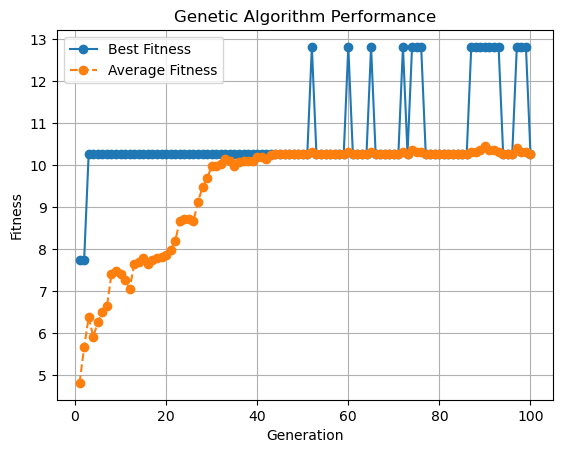

In [38]:
plt.plot(iterations, best_fitness_values, marker='o', label='Best Fitness')
plt.plot(iterations, average_fitness_values, marker='o', linestyle='dashed', label='Average Fitness')
plt.title('Genetic Algorithm Performance')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)
plt.show()